# Stock Data Exploration

This notebook explores the stock data collection and preprocessing pipeline.

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from src.data.collectors.price_collector import PriceCollector
from src.data.processors.technical_indicators import TechnicalIndicators
from src.data.dataset import StockSequenceDataset
from src.data.datamodule import StockDataModule

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 1. Data Collection

In [2]:
# Initialize price collector
collector = PriceCollector(cache_dir='../data/raw/price_cache')

# Define parameters
symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
start_date = '2020-01-01'
end_date = '2023-12-31'

# Fetch data
print("Fetching stock data...")
stock_data = collector.fetch_multiple_stocks(symbols, start_date, end_date)

# Display basic info
for symbol, df in stock_data.items():
    print(f"\n{symbol}: {len(df)} trading days")
    print(f"Date range: {df.index.min()} to {df.index.max()}")
    print(f"Columns: {list(df.columns[:10])}...")

Fetching stock data...

AAPL: 1006 trading days
Date range: 2020-01-02 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
Columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'symbol', 'returns', 'log_returns']...

MSFT: 1006 trading days
Date range: 2020-01-02 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
Columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'symbol', 'returns', 'log_returns']...

GOOGL: 1006 trading days
Date range: 2020-01-02 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
Columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'symbol', 'returns', 'log_returns']...

AMZN: 1006 trading days
Date range: 2020-01-02 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
Columns: ['open', 'high', 'low', 'close', 'volume', 'dividends', 'stock splits', 'symbol', 'returns', 'log_returns']...

TSLA: 1006 trading days
Date range: 2020-01-02 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
Columns: ['open', 'high', 'low', 'cl

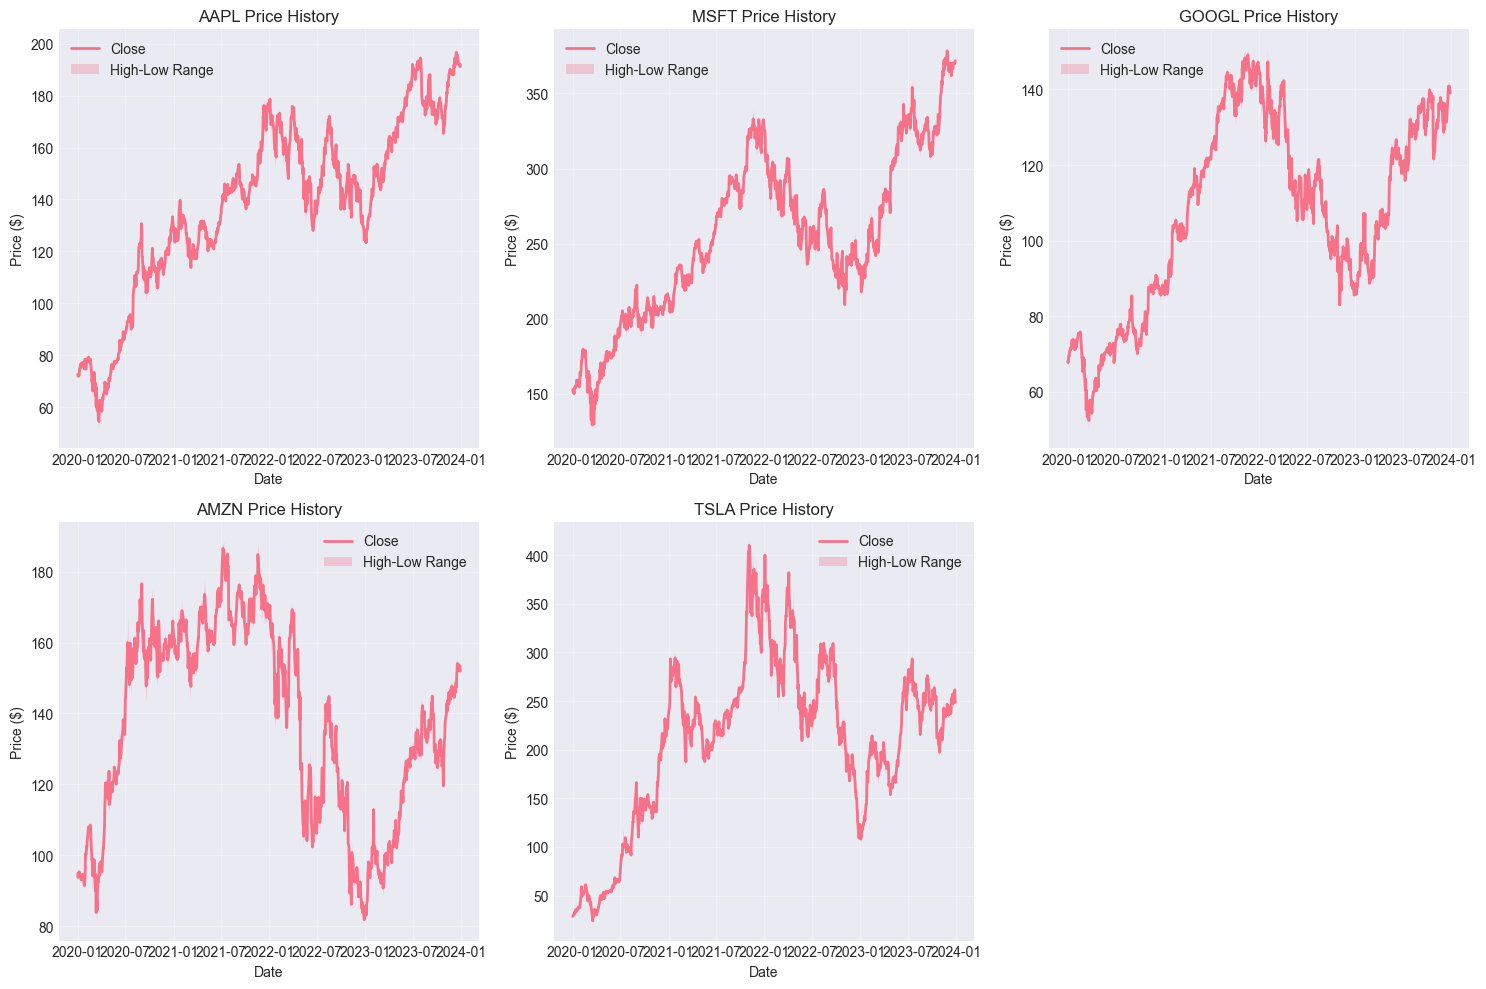

In [3]:
# Visualize price data
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (symbol, df) in enumerate(stock_data.items()):
    axes[i].plot(df.index, df['close'], label='Close', linewidth=2)
    axes[i].fill_between(df.index, df['low'], df['high'], alpha=0.3, label='High-Low Range')
    axes[i].set_title(f'{symbol} Price History')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Price ($)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

# Remove extra subplot
fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 2. Data Quality Check

In [4]:
# Check data quality
quality_metrics = {}

for symbol, df in stock_data.items():
    metrics = collector.validate_data_quality(df)
    quality_metrics[symbol] = metrics
    
    print(f"\n{symbol} Data Quality:")
    print(f"  Total rows: {metrics['total_rows']}")
    print(f"  Date range: {metrics['date_range'][0]} to {metrics['date_range'][1]}")
    print(f"  Missing values: {sum(metrics['missing_values'].values())}")
    print(f"  Zero volume days: {metrics['zero_volumes']}")
    print(f"  Price anomalies (>50% change): {metrics['price_anomalies']}")
    print(f"  Data gaps: {len(metrics['data_gaps'])}")


AAPL Data Quality:
  Total rows: 1006
  Date range: 2020-01-02 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
  Missing values: 2
  Zero volume days: 0
  Price anomalies (>50% change): 0
  Data gaps: 36

MSFT Data Quality:
  Total rows: 1006
  Date range: 2020-01-02 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
  Missing values: 2
  Zero volume days: 0
  Price anomalies (>50% change): 0
  Data gaps: 36

GOOGL Data Quality:
  Total rows: 1006
  Date range: 2020-01-02 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
  Missing values: 2
  Zero volume days: 0
  Price anomalies (>50% change): 0
  Data gaps: 36

AMZN Data Quality:
  Total rows: 1006
  Date range: 2020-01-02 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
  Missing values: 2
  Zero volume days: 0
  Price anomalies (>50% change): 0
  Data gaps: 36

TSLA Data Quality:
  Total rows: 1006
  Date range: 2020-01-02 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
  Missing values: 2
  Zero volume days: 0
  Price anomalies (>50% change): 0
  Data gap

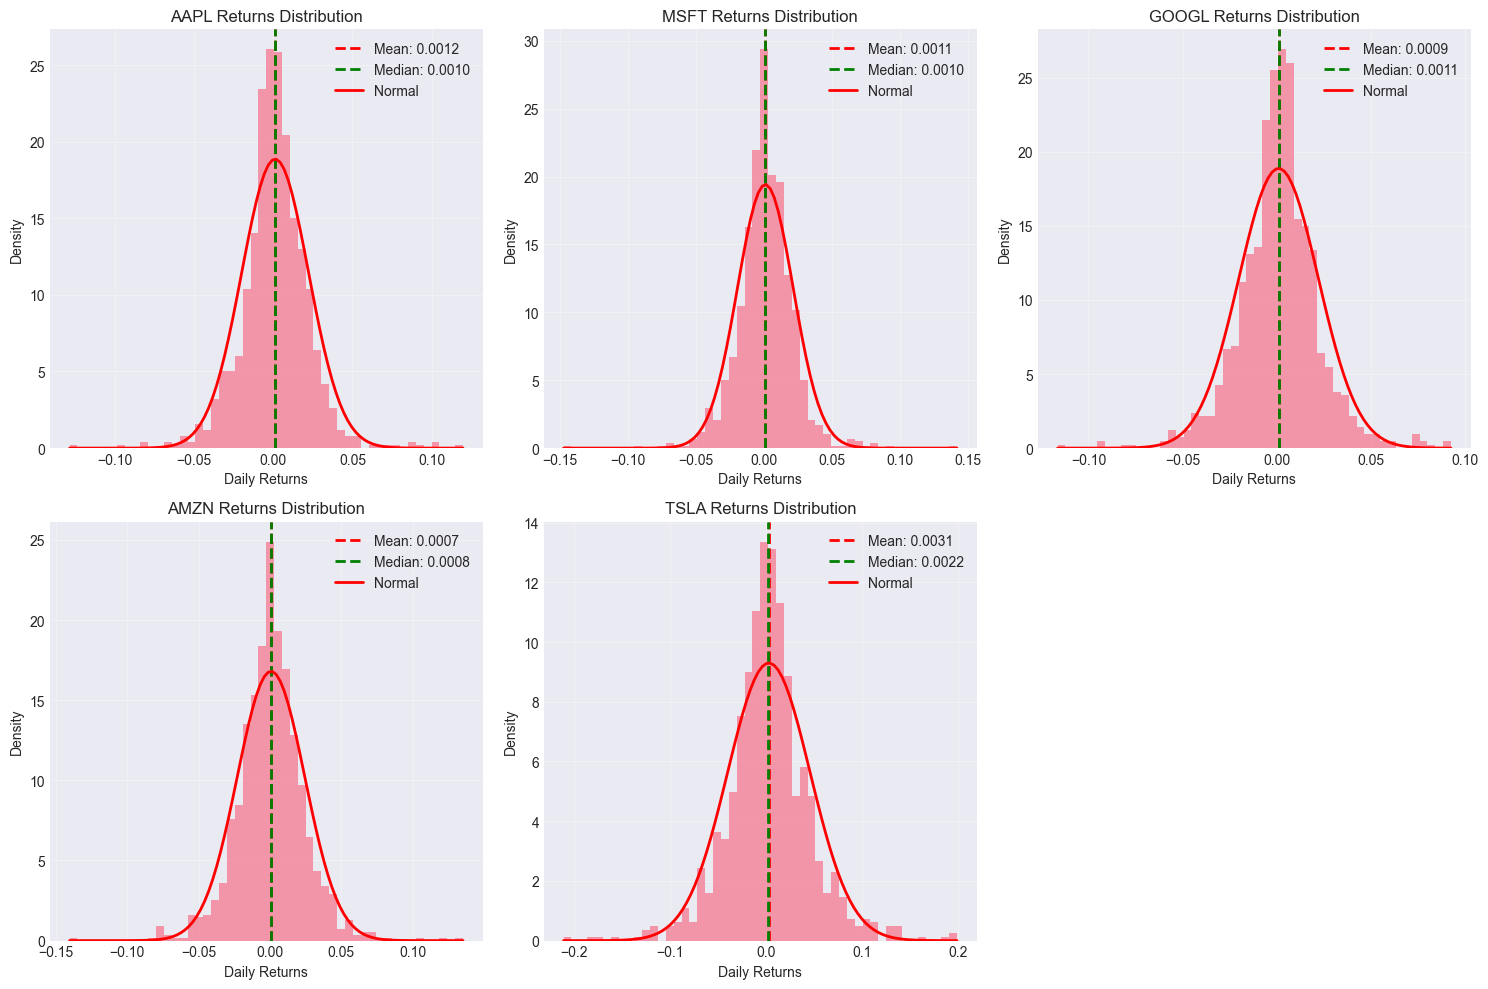

In [5]:
# Visualize returns distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, (symbol, df) in enumerate(stock_data.items()):
    returns = df['returns'].dropna()
    
    # Histogram
    axes[i].hist(returns, bins=50, alpha=0.7, density=True)
    axes[i].axvline(returns.mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {returns.mean():.4f}')
    axes[i].axvline(returns.median(), color='green', linestyle='dashed', linewidth=2, label=f'Median: {returns.median():.4f}')
    
    # Add normal distribution overlay
    from scipy import stats
    x = np.linspace(returns.min(), returns.max(), 100)
    axes[i].plot(x, stats.norm.pdf(x, returns.mean(), returns.std()), 'r-', linewidth=2, label='Normal')
    
    axes[i].set_title(f'{symbol} Returns Distribution')
    axes[i].set_xlabel('Daily Returns')
    axes[i].set_ylabel('Density')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

fig.delaxes(axes[5])
plt.tight_layout()
plt.show()

## 3. Technical Indicators

In [6]:
# Add technical indicators
indicators = TechnicalIndicators()

# Process first stock as example
symbol = 'AAPL'
df_with_indicators = indicators.add_all_indicators(stock_data[symbol].copy())

print(f"Original columns: {len(stock_data[symbol].columns)}")
print(f"After indicators: {len(df_with_indicators.columns)}")
print(f"\nNew indicators added: {len(df_with_indicators.columns) - len(stock_data[symbol].columns)}")

# Show some indicator examples
indicator_examples = ['rsi_14', 'macd', 'bb_upper', 'atr_14', 'obv']
print("\nSample indicators:")
print(df_with_indicators[indicator_examples].tail())

[X] Please install TA-Lib to use 2crows. (pip install TA-Lib)
[X] Please install TA-Lib to use 3blackcrows. (pip install TA-Lib)
[X] Please install TA-Lib to use 3inside. (pip install TA-Lib)
[X] Please install TA-Lib to use 3linestrike. (pip install TA-Lib)
[X] Please install TA-Lib to use 3outside. (pip install TA-Lib)
[X] Please install TA-Lib to use 3starsinsouth. (pip install TA-Lib)
[X] Please install TA-Lib to use 3whitesoldiers. (pip install TA-Lib)
[X] Please install TA-Lib to use abandonedbaby. (pip install TA-Lib)
[X] Please install TA-Lib to use advanceblock. (pip install TA-Lib)
[X] Please install TA-Lib to use belthold. (pip install TA-Lib)
[X] Please install TA-Lib to use breakaway. (pip install TA-Lib)
[X] Please install TA-Lib to use closingmarubozu. (pip install TA-Lib)
[X] Please install TA-Lib to use concealbabyswall. (pip install TA-Lib)
[X] Please install TA-Lib to use counterattack. (pip install TA-Lib)
[X] Please install TA-Lib to use darkcloudcover. (pip instal

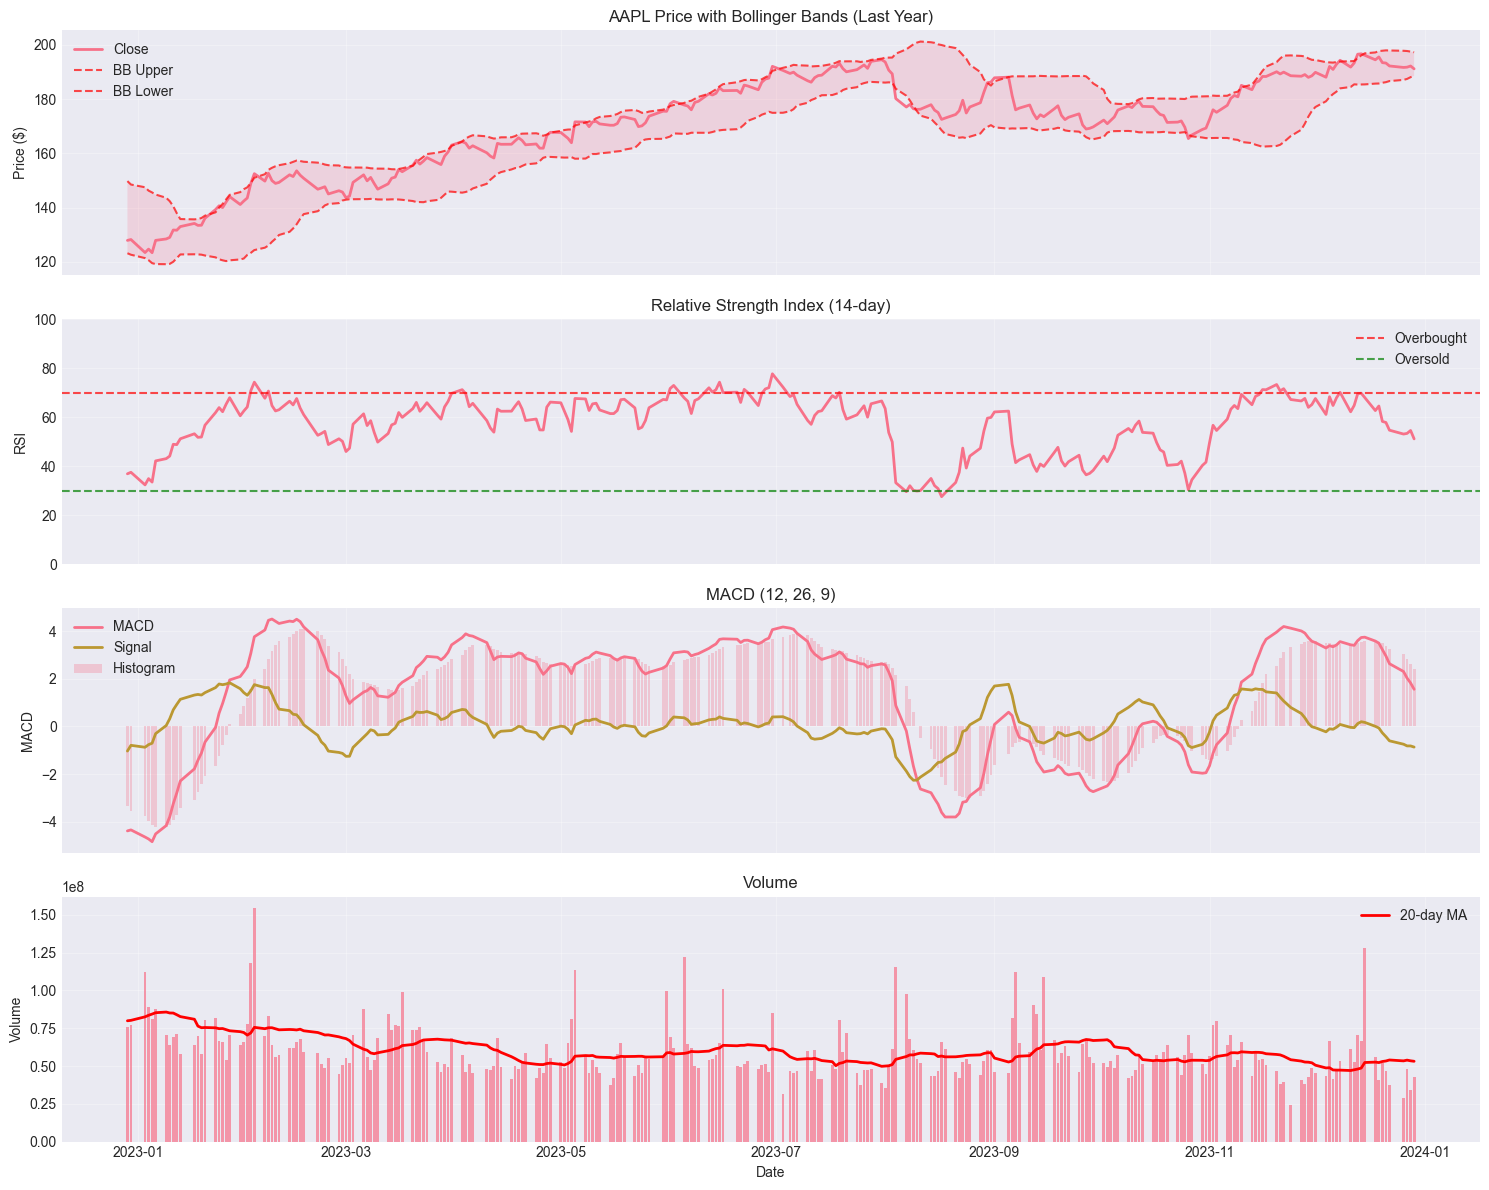

In [7]:
# Visualize key indicators
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Price with Bollinger Bands
axes[0].plot(df_with_indicators.index[-252:], df_with_indicators['close'][-252:], label='Close', linewidth=2)
axes[0].plot(df_with_indicators.index[-252:], df_with_indicators['bb_upper'][-252:], 'r--', label='BB Upper', alpha=0.7)
axes[0].plot(df_with_indicators.index[-252:], df_with_indicators['bb_lower'][-252:], 'r--', label='BB Lower', alpha=0.7)
axes[0].fill_between(df_with_indicators.index[-252:], 
                     df_with_indicators['bb_lower'][-252:], 
                     df_with_indicators['bb_upper'][-252:], 
                     alpha=0.2)
axes[0].set_ylabel('Price ($)')
axes[0].set_title(f'{symbol} Price with Bollinger Bands (Last Year)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# RSI
axes[1].plot(df_with_indicators.index[-252:], df_with_indicators['rsi_14'][-252:], linewidth=2)
axes[1].axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought')
axes[1].axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold')
axes[1].set_ylabel('RSI')
axes[1].set_title('Relative Strength Index (14-day)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(0, 100)

# MACD
axes[2].plot(df_with_indicators.index[-252:], df_with_indicators['macd'][-252:], label='MACD', linewidth=2)
axes[2].plot(df_with_indicators.index[-252:], df_with_indicators['macd_signal'][-252:], label='Signal', linewidth=2)
axes[2].bar(df_with_indicators.index[-252:], df_with_indicators['macd_hist'][-252:], label='Histogram', alpha=0.3)
axes[2].set_ylabel('MACD')
axes[2].set_title('MACD (12, 26, 9)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Volume
axes[3].bar(df_with_indicators.index[-252:], df_with_indicators['volume'][-252:], alpha=0.7)
axes[3].plot(df_with_indicators.index[-252:], df_with_indicators['volume_sma_20'][-252:], 'r-', label='20-day MA', linewidth=2)
axes[3].set_ylabel('Volume')
axes[3].set_xlabel('Date')
axes[3].set_title('Volume')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Feature Correlation Analysis

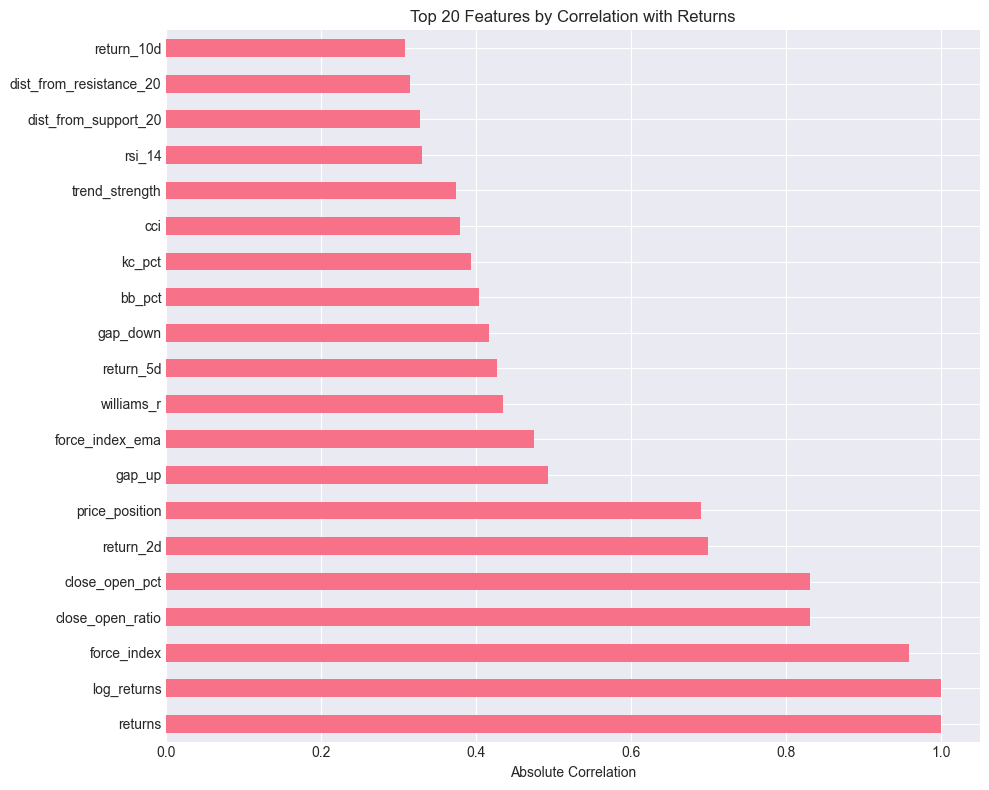

Top 10 most correlated features:
returns             1.000000
log_returns         0.999861
force_index         0.958201
close_open_ratio    0.830675
close_open_pct      0.830675
return_2d           0.699564
price_position      0.689664
gap_up              0.492118
force_index_ema     0.474879
williams_r          0.434457
dtype: float64


In [8]:
# Calculate feature importance/correlation
feature_importance = indicators.calculate_feature_importance(
    df_with_indicators.dropna(), 
    target_col='returns'
)

# Top 20 most correlated features
top_features = feature_importance.head(20)

plt.figure(figsize=(10, 8))
top_features.plot(kind='barh')
plt.title('Top 20 Features by Correlation with Returns')
plt.xlabel('Absolute Correlation')
plt.tight_layout()
plt.show()

print("Top 10 most correlated features:")
print(top_features.head(10))

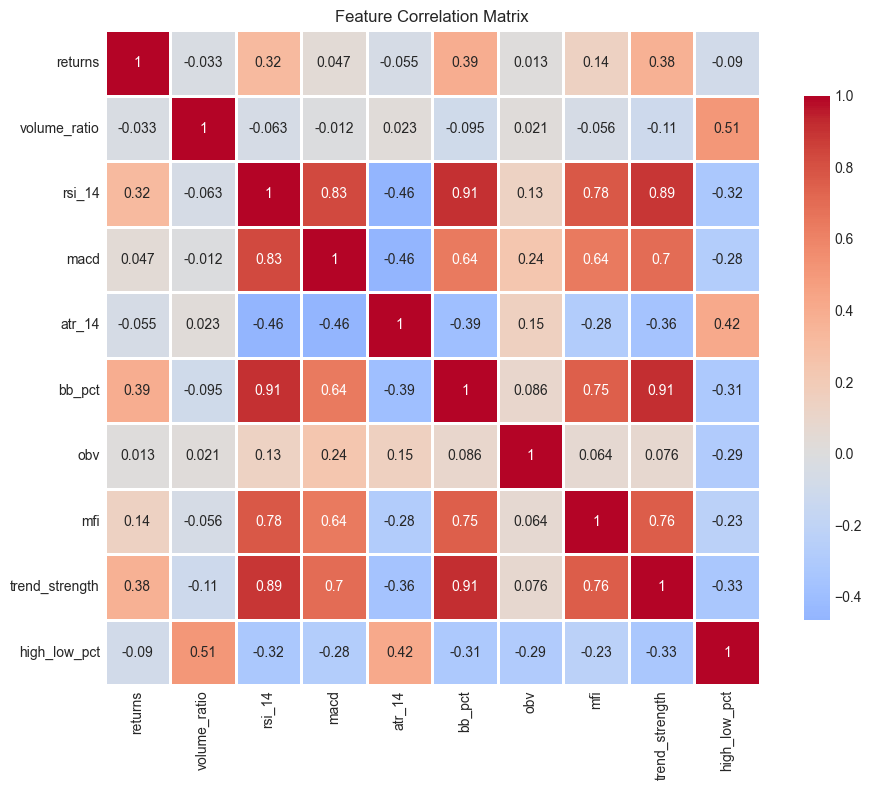

In [9]:
# Correlation heatmap of selected features
selected_features = ['returns', 'volume_ratio', 'rsi_14', 'macd', 'atr_14', 
                    'bb_pct', 'obv', 'mfi', 'trend_strength', 'high_low_pct']

correlation_matrix = df_with_indicators[selected_features].dropna().corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

## 5. Dataset Creation and Sequences

In [10]:
# Create dataset
sequence_length = 60
prediction_horizon = 5

# Add indicators to all stocks
processed_data = {}
for symbol, df in stock_data.items():
    processed_data[symbol] = indicators.add_all_indicators(df)

# Create dataset
dataset = StockSequenceDataset(
    data=processed_data,
    sequence_length=sequence_length,
    prediction_horizon=prediction_horizon,
    target_column='returns',
    scale_features=True,
    target_type='regression'
)

print(f"Total sequences created: {len(dataset)}")
print(f"Features used: {len(dataset.get_feature_names())}")
print(f"\nFeature names (first 20): {dataset.get_feature_names()[:20]}")

# Sample sequence
sample = dataset[0]
print(f"\nSample sequence shape: {sample['sequence'].shape}")
print(f"Sample target shape: {sample['target'].shape}")
print(f"Sample metadata: {sample['metadata']}")

[X] Please install TA-Lib to use 2crows. (pip install TA-Lib)
[X] Please install TA-Lib to use 3blackcrows. (pip install TA-Lib)
[X] Please install TA-Lib to use 3inside. (pip install TA-Lib)
[X] Please install TA-Lib to use 3linestrike. (pip install TA-Lib)
[X] Please install TA-Lib to use 3outside. (pip install TA-Lib)
[X] Please install TA-Lib to use 3starsinsouth. (pip install TA-Lib)
[X] Please install TA-Lib to use 3whitesoldiers. (pip install TA-Lib)
[X] Please install TA-Lib to use abandonedbaby. (pip install TA-Lib)
[X] Please install TA-Lib to use advanceblock. (pip install TA-Lib)
[X] Please install TA-Lib to use belthold. (pip install TA-Lib)
[X] Please install TA-Lib to use breakaway. (pip install TA-Lib)
[X] Please install TA-Lib to use closingmarubozu. (pip install TA-Lib)
[X] Please install TA-Lib to use concealbabyswall. (pip install TA-Lib)
[X] Please install TA-Lib to use counterattack. (pip install TA-Lib)
[X] Please install TA-Lib to use darkcloudcover. (pip instal

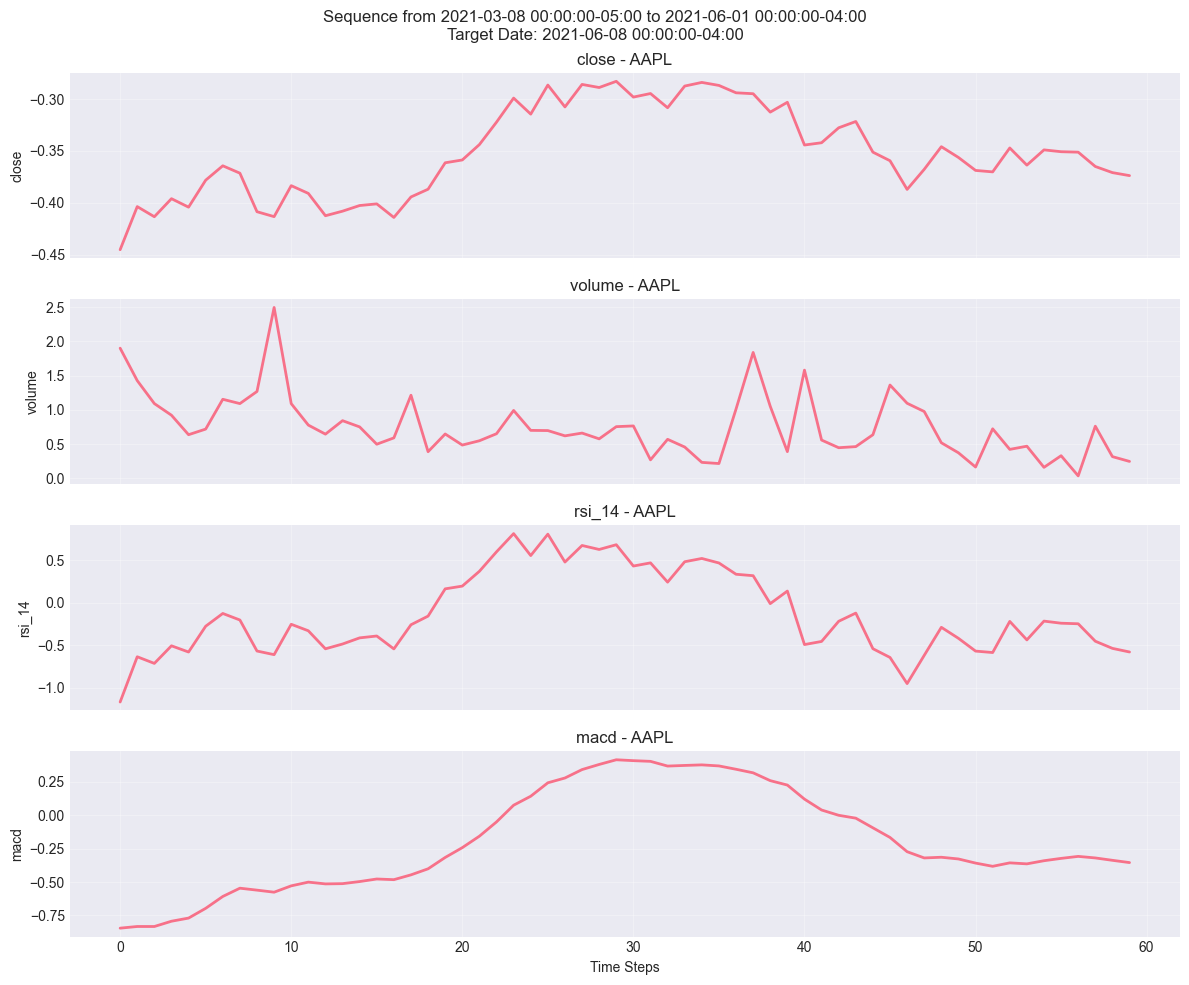

In [11]:
# Visualize a sample sequence
sample_idx = 100
sample = dataset[sample_idx]
sequence = sample['sequence'].numpy()
metadata = sample['metadata']

# Get feature names
feature_names = dataset.get_feature_names()

# Plot some key features from the sequence
features_to_plot = ['close', 'volume', 'rsi_14', 'macd']
feature_indices = [feature_names.index(f) for f in features_to_plot if f in feature_names]

fig, axes = plt.subplots(len(feature_indices), 1, figsize=(12, 10), sharex=True)
if len(feature_indices) == 1:
    axes = [axes]

for i, (feat_idx, feat_name) in enumerate(zip(feature_indices, features_to_plot)):
    axes[i].plot(sequence[:, feat_idx], linewidth=2)
    axes[i].set_ylabel(feat_name)
    axes[i].set_title(f'{feat_name} - {metadata["symbol"]}')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Time Steps')
fig.suptitle(f'Sequence from {metadata["start_date"]} to {metadata["end_date"]}\nTarget Date: {metadata["target_date"]}')
plt.tight_layout()
plt.show()

## 6. DataModule Testing

In [12]:
# Test DataModule
datamodule = StockDataModule(
    symbols=symbols,
    start_date=start_date,
    end_date=end_date,
    sequence_length=60,
    prediction_horizon=1,
    batch_size=32,
    target_type='classification',
    add_technical_indicators=True,
    add_market_data=True,
    cache_dir='../data/raw/price_cache'
)

# Prepare and setup
datamodule.prepare_data()
datamodule.setup()

# Get dataloaders
train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()
test_loader = datamodule.test_dataloader()

print(f"Number of features: {datamodule.get_num_features()}")
print(f"Number of classes: {datamodule.get_num_classes()}")
print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

[X] Please install TA-Lib to use 2crows. (pip install TA-Lib)
[X] Please install TA-Lib to use 3blackcrows. (pip install TA-Lib)
[X] Please install TA-Lib to use 3inside. (pip install TA-Lib)
[X] Please install TA-Lib to use 3linestrike. (pip install TA-Lib)
[X] Please install TA-Lib to use 3outside. (pip install TA-Lib)
[X] Please install TA-Lib to use 3starsinsouth. (pip install TA-Lib)
[X] Please install TA-Lib to use 3whitesoldiers. (pip install TA-Lib)
[X] Please install TA-Lib to use abandonedbaby. (pip install TA-Lib)
[X] Please install TA-Lib to use advanceblock. (pip install TA-Lib)
[X] Please install TA-Lib to use belthold. (pip install TA-Lib)
[X] Please install TA-Lib to use breakaway. (pip install TA-Lib)
[X] Please install TA-Lib to use closingmarubozu. (pip install TA-Lib)
[X] Please install TA-Lib to use concealbabyswall. (pip install TA-Lib)
[X] Please install TA-Lib to use counterattack. (pip install TA-Lib)
[X] Please install TA-Lib to use darkcloudcover. (pip instal

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [ ]:
# Check batch
batch = next(iter(train_loader))
print("Batch keys:", batch.keys())
print(f"Sequence shape: {batch['sequence'].shape}")
print(f"Target shape: {batch['target'].shape}")

# Target distribution for classification
if datamodule.target_type == 'classification':
    targets = []
    for batch in train_loader:
        targets.extend(batch['target'].numpy())
    
    plt.figure(figsize=(8, 6))
    plt.hist(targets, bins=datamodule.get_num_classes())
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Target Class Distribution (0=Down, 1=Neutral, 2=Up)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Class balance
    unique, counts = np.unique(targets, return_counts=True)
    for cls, count in zip(unique, counts):
        print(f"Class {cls}: {count} samples ({count/len(targets)*100:.1f}%)")

## 7. Summary Statistics

In [ ]:
# Summary statistics for all stocks
summary_stats = pd.DataFrame()

for symbol, df in processed_data.items():
    stats = {
        'Symbol': symbol,
        'Days': len(df),
        'Start': df.index.min().strftime('%Y-%m-%d'),
        'End': df.index.max().strftime('%Y-%m-%d'),
        'Avg Return': df['returns'].mean() * 100,
        'Volatility': df['returns'].std() * 100,
        'Sharpe Ratio': df['returns'].mean() / df['returns'].std() * np.sqrt(252),
        'Max Drawdown': (df['close'] / df['close'].cummax() - 1).min() * 100,
        'Avg Volume': df['volume'].mean(),
        'Price Range': f"${df['close'].min():.2f} - ${df['close'].max():.2f}"
    }
    summary_stats = pd.concat([summary_stats, pd.DataFrame([stats])], ignore_index=True)

print("Summary Statistics for All Stocks:")
print(summary_stats.to_string(index=False))

# Save summary
summary_stats.to_csv('../results/data_summary.csv', index=False)
print("\nSummary saved to ../results/data_summary.csv")